# Problem Statement

You are given the original and degraded versions of a few images. Your task is to write a GAN which can fix the degraded images.

Complete the function `fix` at the end of the "Evaluation" block so that it can take a degraded image, and return a fixed image (that looks as much like the original non-degraded version as possible).

Before submission, get this notebook in a state such that the `fix` function can directly be called on an image. Also, please make sure that 5 images are displayed in the result block. Without that, your submission will not be evaluated.

#Setup

## Intended Structure after Setup

Run the blocks in this section to get the following directory structure:
```
/content
│
└───rephrase-pubfig831
    │
    └───correct
    │   │
    │   └───train
    │   │   │
    │   │   └───Adam Sandler
    │   │   │   │   train__000001-000000.jpg
    │   │   │   │   train__000001-000001.jpg
    │   │   │   │   train__000001-000002.jpg
    │   │   │   │   ...
    │   │   │
    │   │   └───Alec Baldwin
    │   │   │   │   train__000002-000000.jpg
    │   │   │   │   train__000002-000001.jpg
    │   │   │   │   ...
    │   │   │
    │   │   └───Angelina Jolie
    │   │   │   │   train__000003-000000.jpg
    │   │   │   │   train__000003-000001.jpg
    │   │   │   │   ...
    │   │   │
    │   │   │ ...
    │   │
    │   └───test
    │       │
    │       └───Adam Sandler
    │       │   │   test__000001-000000.jpg
    │       │   │   test__000001-000001.jpg
    │       │   │   ...
    │       │
    │       └───Alec Baldwin
    │       │   │   test__000002-000000.jpg
    │       │   │   ...
    │       │
    │       └───Angelina Jolie
    │       │   │   test__000003-000000.jpg
    │       │   │   ...
    │       │
    │       │ ...
    │
    │
    └───degraded
        │   <Same directory structure as 'correct'>
```

Every image in the degraded directory is a degraded version of the image with the same name in the correct directory. e.g. `/content/rephrase-pubfig831/degraded/Adam Sandler/train__000001-000002.jpg` is the degraded version of `/content/rephrase-pubfig831/correct/Adam Sandler/train__000001-000002.jpg`

## Installation (pip etc)
Add any other installation commands you want to in this block.

In [0]:
!pip install GPUtil
!pip install tqdm
!pip3 install tensorflow-gpu==2.0.0
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi

  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=e0c1c4272c11207a7a42655748a556d006212b311935da31ab6d972b412e6887
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil
     |████████████████████████████████| 380.8MB 43kB/s 
     |████████████████████████████████| 3.8MB 28.7MB/s 
     |████████████████████████████████| 450kB 43.4MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-e

## Downloading and Generating Dataset
Run this block only once. Do not modify it.

### Imports

In [0]:
import os
from glob import glob
import cv2
import numpy as np
from tqdm import tqdm

import psutil
import humanize
import os
import GPUtil as GPU
import tensorflow as tf

#### Mounting Drive for Saving Checkpoint

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Degrading Images

In [0]:
def degrade(path: str) -> None:
    """Load image at `input_path`, distort and save as `output_path`"""
    SHIFT = 2
    image = cv2.imread(path)
    to_swap = np.random.choice([False, True], image.shape[:2], p=[.8, .2])
    swap_indices = np.where(to_swap[:-SHIFT] & ~to_swap[SHIFT:])
    swap_vals = image[swap_indices[0] + SHIFT, swap_indices[1]]
    image[swap_indices[0] + SHIFT, swap_indices[1]] = image[swap_indices]
    image[swap_indices] = swap_vals
    cv2.imwrite(path, image)

!wget http://briancbecker.com/files/downloads/pubfig83lfw/pubfig83lfw_raw_in_dirs.zip
!unzip -q pubfig83lfw_raw_in_dirs.zip
!rm pubfig83lfw_raw_in_dirs.zip
!mkdir rephrase-pubfig831
!mv pubfig83lfw_raw_in_dirs rephrase-pubfig831/correct
!rm -r rephrase-pubfig831/correct/distract
!cp -r rephrase-pubfig831/correct rephrase-pubfig831/degraded

for image_path in tqdm(glob('rephrase-pubfig831/degraded/*/*/*.jpg')):
  degrade(image_path)

--2019-10-23 15:32:28--  http://briancbecker.com/files/downloads/pubfig83lfw/pubfig83lfw_raw_in_dirs.zip
Resolving briancbecker.com (briancbecker.com)... 162.241.216.158
Connecting to briancbecker.com (briancbecker.com)|162.241.216.158|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400247922 (382M) [application/zip]
Saving to: ‘pubfig83lfw_raw_in_dirs.zip’

pubfig83lfw_raw_in_ 100%[===================>] 381.71M  6.77MB/s    in 2m 27s  

2019-10-23 15:34:57 (2.60 MB/s) - ‘pubfig83lfw_raw_in_dirs.zip’ saved [400247922/400247922]

mkdir: cannot create directory ‘rephrase-pubfig831’: File exists


100%|██████████| 13002/13002 [01:05<00:00, 199.31it/s]


# **Checking Free Memory**
This block is just so that you can have an idea of the resources you have at hand on the Google Collab system.

In [0]:
gpu = GPU.getGPUs()[0]
process = psutil.Process(os.getpid())
print(f"Gen RAM: Free {humanize.naturalsize(psutil.virtual_memory().available)} | Proc size {humanize.naturalsize(process.memory_info().rss)}")
print(f"GPU RAM: Free {gpu.memoryFree:.0f}MB | Used {gpu.memoryUsed:.0f}MB | Util {gpu.memoryUtil*100:.0f}% | Total {gpu.memoryTotal:.0f}MB")

Gen RAM: Free 12.7 GB | Proc size 367.4 MB
GPU RAM: Free 11441MB | Used 0MB | Util 0% | Total 11441MB


# **Main Code**

## Data Loading

In [0]:
PATCH_SIZE = [128, 128, 3]
BATCH_SIZE = 32
def load_image(path, crop=True):
  image = tf.image.decode_image(tf.io.read_file(path))
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image
def create_dataset_gen(corrupted_path, correct_path, patch_size=[128, 128]):
  corrupted_images = tf.io.gfile.glob(os.path.join(corrupted_path, "*.jpg"))
  correct_images = tf.io.gfile.glob(os.path.join(correct_path, "*.jpg"))
  def gen_fn():
    for corrupt, correct in zip(corrupted_images, correct_images):
      correct = load_image(correct)
      corrupt = load_image(corrupt)
      h, w, c = correct.shape
      patchH, patchW = patch_size
      for pH in range(0, h // patchH, patchH):
        for pW in range(0, w // patchW, patchW):
          if pH + patchH <= h and pW + patchW <= w:
            yield (corrupt[pH : pH + patchH, pW : pW + patchW],
                   correct[pH : pH + patchH, pW : pW + patchW])
  return gen_fn
def create_dataset(strategy):
  dataset_generator = create_dataset_gen(
      "/content/rephrase-pubfig831/degraded/train/*",
      "/content/rephrase-pubfig831/correct/train/*",
      patch_size=PATCH_SIZE[:-1])
  dataset = tf.data.Dataset.from_generator(dataset_generator,
                                          output_types=(tf.float32, tf.float32),
                                          output_shapes=(tf.TensorShape(PATCH_SIZE),
                                                          tf.TensorShape(PATCH_SIZE)))
  dataset = (dataset
             .shuffle(128, reshuffle_each_iteration=True)
             .batch(BATCH_SIZE, drop_remainder=True)
             .repeat())
  return strategy.experimental_distribute_dataset(dataset)

## Structure

### **Constants and Hyperparemeters**

In [0]:
CONFIG = dict(
    generator=dict(trunk_size=4, alpha=0.1, skip_length=3),
    discriminator=dict(trunk_size=5),
    training=dict(
        checkpoint_path="/content/drive/My Drive/rephrase_ai/checkpoints/ckpt",
        gamma=0.7,# Perceptual Loss
        eta=1e-3, # Adversarial Loss
        g_learning_rate=0.0001,
        d_learning_rate=0.0004,
        num_steps=int(1e4),
        checkpoint_step=int(1e3)))

### Generator Model

In [0]:
import functools
conv = functools.partial(
    tf.keras.layers.Conv2D,
    strides=[1, 1],
    kernel_size=[3, 3],
    use_bias=True,
    bias_initializer="zeros",
    kernel_initializer="he_normal",
    padding="same")
depthwise = functools.partial(
    tf.keras.layers.DepthwiseConv2D,
    kernel_size=[3, 3],
    strides=[1, 1],
    depth_multiplier=1,
    use_bias=True,
    bias_initializer="zeros",
    padding="same",
    depthwise_initializer="he_normal")

bn = tf.keras.layers.BatchNormalization
dense = tf.keras.layers.Dense

class ResidualBlock(tf.keras.layers.Layer):
  def __init__(self, config, growth_channel=32, *args, **kwargs):
    super(ResidualBlock, self).__init__(*args, **kwargs)
    self._config = config
    self._conv = {
        "residual_conv_%d" % i: conv(growth_channel,
                                     name="residual_conv_%d" % i) \
        for i in range(0, self._config['skip_length'])}
    self._alpha = self._config['alpha']
    self._lrelu = tf.keras.layers.LeakyReLU()
  def call(self, inputs):
    length = self._config["skip_length"]
    x = inputs
    for i in range(0, length - 1):
      x = self._lrelu(self._conv["residual_conv_%d" % i](x))
    x = self._conv["residual_conv_%d" % (length - 1)](x)
    return inputs + self._alpha * x

class Generator(tf.keras.models.Model):
  def __init__(self, growth_channel=32, *args, **kwargs):
    super(Generator, self).__init__(*args, **kwargs)
    self._config = CONFIG['generator']
    self._lrelu = tf.keras.layers.LeakyReLU()
    self._first_conv = conv(growth_channel, name="first_conv")
    self._resblocks = {
        "resblock_%d" % i: ResidualBlock(self._config, growth_channel,
                                         name="resblock_%d" % i) \
        for i in range(0, self._config["trunk_size"])}
    self._last_conv_1 = conv(growth_channel, name="last_conv_1")
    self._last_conv_2 = conv(3, name="last_conv_2")
  def call(self, inputs):
    features = self._lrelu(self._first_conv(inputs))
    x = features
    for i in range(0, self._config['trunk_size']):
      x = self._resblocks['resblock_%d' % i](x)
    x = x + features
    x = self._lrelu(self._last_conv_1(x))
    return self._last_conv_2(x)

### Discriminator Model

In [0]:
class Discriminator(tf.keras.models.Model):
  def __init__(self, growth_channel=32, *args, **kwargs):
    super(Discriminator, self).__init__(*args, **kwargs)
    self._lrelu = tf.keras.layers.LeakyReLU()
    self._conv = dict()
    self._bn = dict()
    self._config = CONFIG['discriminator']
    self._conv["0_0"] = conv(growth_channel, name="conv_0_0")
    self._bn['0_0'] = bn(name="bn_0_0")
    for i in range(1, self._config['trunk_size']):
      for j in range(1, 3):
        key = "%d_%d" % (i, j)
        self._conv[key] = conv(growth_channel,
                               strides=j, name="conv_%s" % key)
        self._bn[key] = bn(name="bn_%s" % key)
    self._conv["last_conv_1"] = conv(growth_channel, strides=2,
                                     name="last_conv_1")
    self._bn["last_bn"] = bn()
    self._conv["last_conv_2"] = conv(3, strides=2, name="last_conv_2")
    self._dense_1 = dense(1024)
    self._dense_2 = dense(1)
  def call(self, inputs):
    x = self._lrelu(self._bn['0_0'](self._conv['0_0'](inputs)))
    for i in range(1, self._config['trunk_size']):
      for j in range(1, 3):
        key = "%d_%d" % (i, j)
        x = self._conv[key](x)
        x = self._bn[key](x)
        x = self._lrelu(x)
    x = self._lrelu(self._bn["last_bn"](self._conv["last_conv_1"](x)))
    x = self._lrelu(self._conv['last_conv_2'](x))
    x = tf.keras.layers.Flatten()(x)
    x = self._lrelu(self._dense_1(x))
    return self._dense_2(x)

### Loss Functions

In [0]:
def perceptualLoss(weights="imagenet"):
  vgg16 = tf.keras.applications.VGG16(weights=weights, include_top=False)
  for layer in vgg16.layers:
    layer.trainable = False
  features = vgg16.get_layer("block5_conv3").output
  phi = tf.keras.Model(inputs=[vgg16.input], outputs=[features])
  def loss_fn(y_true, y_pred):
    y_true = tf.keras.applications.vgg16.preprocess_input(y_true)
    y_pred = tf.keras.applications.vgg16.preprocess_input(y_pred)
    return tf.reduce_mean(tf.abs(phi(y_true) - phi(y_pred)))
  return loss_fn
def pixelLoss(y_true, y_pred):
  return tf.reduce_mean((y_true - y_pred)**2)

def generatorLoss(y_pred):
  return tf.nn.sigmoid_cross_entropy_with_logits(tf.fill(y_pred.shape, 0.9),
                                                 tf.nn.sigmoid(y_pred))
  
def discLoss(y_true, y_pred):
  real_loss = generatorLoss(y_true)
  fake_loss = tf.nn.sigmoid_cross_entropy_with_logits(tf.zeros_like(y_pred),
                                                      tf.nn.sigmoid(y_pred))
  return fake_loss + real_loss

### Optimizer

In [0]:
def get_optimizers():
  gen_optimizer = tf.keras.optimizers.Adam(learning_rate=CONFIG['training']['g_learning_rate'])
  disc_optimizer = tf.keras.optimizers.Adam(learning_rate=CONFIG['training']['d_learning_rate'])
  return gen_optimizer, disc_optimizer

## Preprocessing

In [0]:
def save_checkpoint(checkpoint):
  path = CONFIG['training']['checkpoint_path']
  prefix = "ckpt"
  path = os.path.join(path, prefix)
  if not tf.io.gfile.exists(path):
    tf.io.gfile.makedirs(path)
  print("Saving Checkpoint: %d" % checkpoint.save_counter)
  return checkpoint.save(path)

def restore_checkpoint(checkpoint, path=CONFIG['training']['checkpoint_path']):
  if tf.io.gfile.exists(path):
    print("Restoring")
    return checkpoint.restore(tf.train.latest_checkpoint(path))

### Setting device to use for tensor operations

In [0]:
assert tf.test.is_gpu_available()
strategy = tf.distribute.OneDeviceStrategy("/gpu:0")

### Initializing weights (if required)

## Training

In [0]:
%load_ext tensorboard
%tensorboard --logdir logs/

In [0]:
def train(strategy, data, summary_writer):
  gamma = CONFIG['training']['gamma']
  eta = CONFIG['training']['eta']
  gen_metric = tf.keras.metrics.Mean()
  disc_metric = tf.keras.metrics.Mean()
  psnr_metric = tf.keras.metrics.Mean()
  gen_optimizer, disc_optimizer = get_optimizers()
  perceptual_loss = perceptualLoss()
  ckpt = tf.train.Checkpoint(
      generator=G,
      discriminator=D,
      gen_optimizer=gen_optimizer,
      disc_optimizer=disc_optimizer,
      gen_metric=gen_metric,
      disc_metric=disc_metric,
      psnr_metric=psnr_metric)
  status = restore_checkpoint(ckpt)

  def distributed_fn(corrupt, correct):
    with tf.GradientTape() as GTape, tf.GradientTape() as DTape:
      fake = G(corrupt)
      disc_real = D(correct)
      disc_fake = D(fake)
      psnr = tf.image.psnr(fake, correct, max_val=1.0)
      adv_gen_loss = tf.reduce_mean(generatorLoss(fake))
      pixel_loss = pixelLoss(correct, fake)
      percep_loss = perceptual_loss(correct, fake)
      adv_disc_loss = tf.reduce_mean(discLoss(disc_real, disc_fake))
      total_gen_loss = pixel_loss + gamma * percep_loss + eta * adv_gen_loss
      gen_metric(total_gen_loss)
      disc_metric(adv_disc_loss)
      psnr_metric(psnr)
      gen_grad = GTape.gradient(total_gen_loss, G.trainable_variables)
      gen_optimizer.apply_gradients(zip(gen_grad, G.trainable_variables))
      disc_grad = DTape.gradient(adv_disc_loss, D.trainable_variables)
      disc_optimizer.apply_gradients(zip(disc_grad, D.trainable_variables))

  def train_step(corrupt, correct):
    strategy.experimental_run_v2(distributed_fn, args=(corrupt, correct))
  
  for step in range(CONFIG['training']['num_steps']):
    try:
      corrupt, correct = next(data)
    except StopIteration:
      break
    train_step(corrupt, correct)
    if status:
      status.assert_consumed()
      status = None
    with summary_writer.as_default():
      tf.summary.scalar("psnr", psnr_metric.result(), gen_optimizer.iterations)
      tf.summary.scalar("gen_loss", gen_metric.result(), gen_optimizer.iterations)
      tf.summary.scalar("disc_loss", disc_metric.result(), gen_optimizer.iterations)
    if step and not step % CONFIG['training']['checkpoint_step']:
      save_checkpoint(ckpt)

In [0]:
with tf.device("/task:0"), strategy.scope():
  G = Generator()
  D = Discriminator()
  dataset = iter(create_dataset(strategy))
  summary_writer = tf.summary.create_file_writer("/content/logs")
  train(strategy, dataset, summary_writer)

58892288/58889256 [==============================] - 1s 0us/step
Saving Checkpoint: 0
Saving Checkpoint: 1
Saving Checkpoint: 2
Saving Checkpoint: 3
Saving Checkpoint: 4
Saving Checkpoint: 5
Saving Checkpoint: 6
Saving Checkpoint: 7
Saving Checkpoint: 8


KeyboardInterrupt: ignored

## Evaluation

#### Downloading Saved Checkpoints

In [0]:
!gdown https://drive.google.com/uc?id=1qHZrqGkIXOvh_FB-GzPJx3knClps8UNW
!unzip best_ckpt.zip
!rm best_ckpt.zip

Downloading...
From: https://drive.google.com/uc?id=1qHZrqGkIXOvh_FB-GzPJx3knClps8UNW
To: /content/best_ckpt.zip
2.49MB [00:00, 76.9MB/s]
Archive:  best_ckpt.zip
  inflating: best_ckpt/checkpoint    
  inflating: best_ckpt/ckpt-9.index  
  inflating: best_ckpt/ckpt-9.data-00000-of-00002  
  inflating: best_ckpt/ckpt-9.data-00001-of-00002  


#### Restoring Checkpoints

In [0]:
G = Generator()
ckpt = tf.train.Checkpoint(generator=G)
restore_checkpoint(ckpt, "best_ckpt")

Restoring


In [0]:
def fix(image: np.ndarray) -> np.ndarray:
    """
    This function should take a degraded image in BGR format as a 250x250x3
    numpy array, and return its fixed version in the same format.
    """
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, 0)
    img = tf.image.convert_image_dtype(img, tf.float32)
    pred = tf.clip_by_value(G(img), 0, 1)
    pred = tf.image.convert_image_dtype(pred, tf.uint8)
    pred = np.squeeze(pred.numpy())
    return cv2.cvtColor(pred, cv2.COLOR_RGB2BGR)

# Results
Run this block after done to look at some of the results of the fix function yourself.

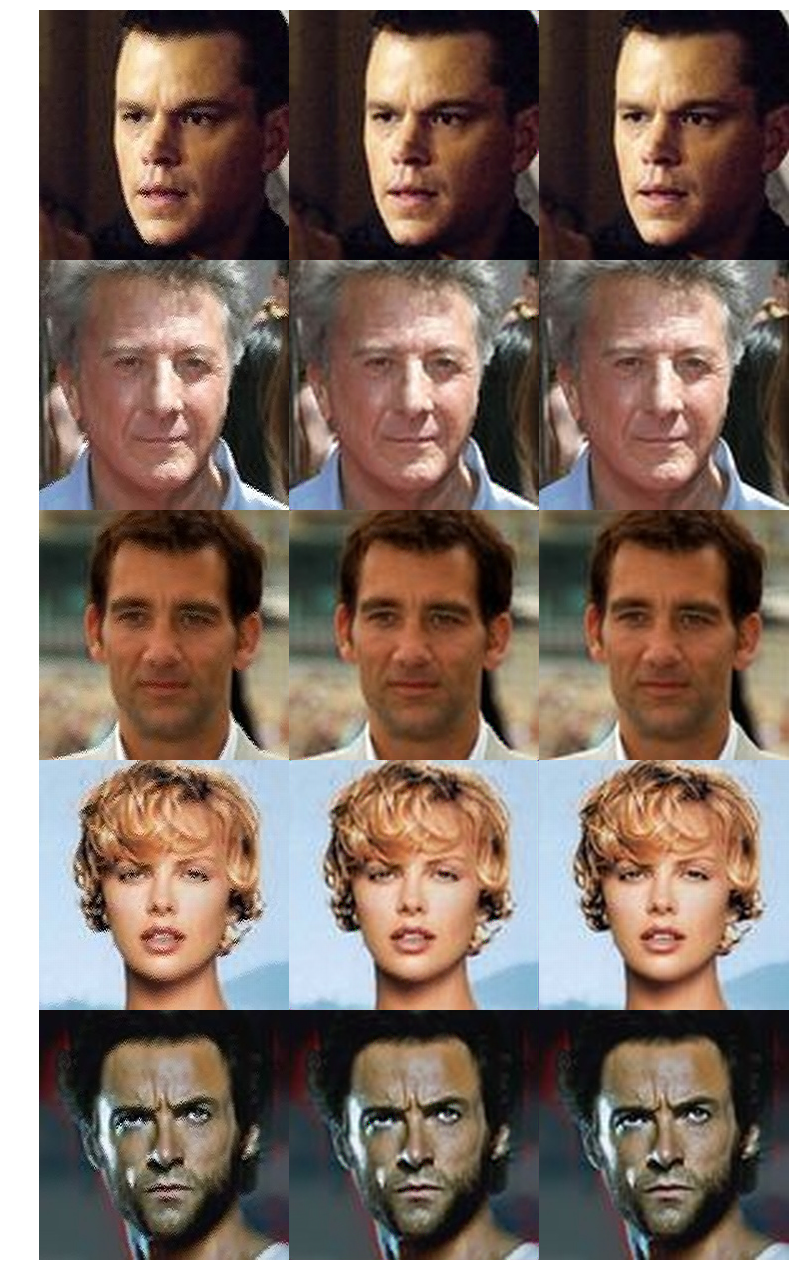

In [0]:
%matplotlib inline

import os
import random
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np

NUM_DISPLAY = 5

files = glob('/content/rephrase-pubfig831/correct/test/*/*')
grid = []
for path in random.sample(files, NUM_DISPLAY):
  correct = cv2.imread(path)
  split = path.split('/')
  degraded = cv2.imread('/'.join([*split[:3], 'degraded', *split[4:]]))
  fixed = fix(degraded)
  grid.append(np.column_stack([degraded, fixed, correct]))
image = np.row_stack(grid)
dpi = float(plt.rcParams['figure.dpi'])
figsize = image.shape[1] / dpi, image.shape[0] / dpi
ax = plt.figure(figsize=figsize).add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(image[..., ::-1])
plt.show()